## Twitter Sentiment Analysis

#### By: Naveen B

- The objective of this task is to detect hate speech in tweets.
- For the sake of simplicity, we say a tweet contains hate speech if it has a racist or sexist sentiment associated with it.
- So, the task is to classify racist or sexist tweets from other tweets.

#### Importing required libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import re
import nltk
from nltk.stem.porter import *
import string
from wordcloud import WordCloud
import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)
from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import f1_score,confusion_matrix
from mlxtend.plotting import plot_confusion_matrix

#### Importing dataset

In [2]:
train=pd.read_csv("train_E6oV3lV.csv")
test=pd.read_csv("test_tweets_anuFYb8.csv")

In [3]:
train.head()

,id,label,tweet
0,1,0,@user when a father is dysfunctional and is s...
1,2,0,@user @user thanks for #lyft credit i can't us...
2,3,0,bihday your majesty
3,4,0,#model i love u take with u all the time in ...
4,5,0,factsguide: society now #motivation


In [4]:
test.head()

,id,tweet
0,31963,#studiolife #aislife #requires #passion #dedic...
1,31964,@user #white #supremacists want everyone to s...
2,31965,safe ways to heal your #acne!! #altwaystohe...
3,31966,is the hp and the cursed child book up for res...
4,31967,"3rd #bihday to my amazing, hilarious #nephew..."


In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31962 entries, 0 to 31961
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      31962 non-null  int64 
 1   label   31962 non-null  int64 
 2   tweet   31962 non-null  object
dtypes: int64(2), object(1)
memory usage: 749.2+ KB


In [6]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17197 entries, 0 to 17196
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      17197 non-null  int64 
 1   tweet   17197 non-null  object
dtypes: int64(1), object(1)
memory usage: 268.8+ KB


#### Data Inspection

In [7]:
train[train["label"]==0]  ## Non Hate tweets

,id,label,tweet
0,1,0,@user when a father is dysfunctional and is s...
1,2,0,@user @user thanks for #lyft credit i can't us...
2,3,0,bihday your majesty
3,4,0,#model i love u take with u all the time in ...
4,5,0,factsguide: society now #motivation
...,...,...,...
31956,31957,0,off fishing tomorrow @user carnt wait first ti...
31957,31958,0,ate @user isz that youuu?ðððððð...
31958,31959,0,to see nina turner on the airwaves trying to...
31959,31960,0,listening to sad songs on a monday morning otw...


In [8]:
train[train["label"]==1]  ## Non Hate tweets

,id,label,tweet
13,14,1,@user #cnn calls #michigan middle school 'buil...
14,15,1,no comment! in #australia #opkillingbay #se...
17,18,1,retweet if you agree!
23,24,1,@user @user lumpy says i am a . prove it lumpy.
34,35,1,it's unbelievable that in the 21st century we'...
...,...,...,...
31934,31935,1,lady banned from kentucky mall. @user #jcpenn...
31946,31947,1,@user omfg i'm offended! i'm a mailbox and i'...
31947,31948,1,@user @user you don't have the balls to hashta...
31948,31949,1,"makes you ask yourself, who am i? then am i a..."


In [9]:
train["label"].value_counts()

0    29720
1     2242
Name: label, dtype: int64

In [10]:
train["label"].value_counts(normalize=True)

0    0.929854
1    0.070146
Name: label, dtype: float64

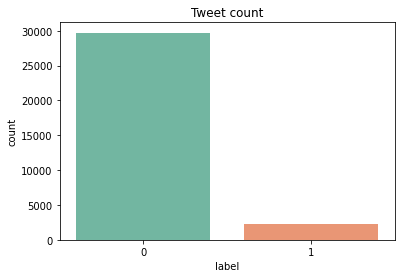

In [11]:
sns.countplot(train["label"],palette="Set2")
plt.title("Tweet count")
plt.show()

- Only 7% of  tweets are hate tweets  rest 93% are Non-hate tweets in train data

Lets check length of characters of both Train and Test set

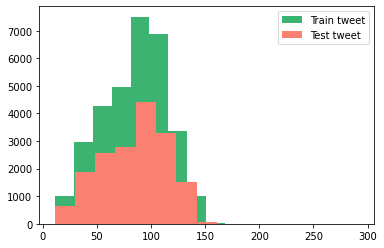

In [12]:
plt.hist(train["tweet"].str.len(),bins=15,label="Train tweet",color="mediumseagreen")
plt.hist(test["tweet"].str.len(),bins=15,label="Test tweet",color="salmon")
plt.legend()
plt.show()

#### Data Cleaning

combining both traina and test dataset for cleaning

In [13]:
combined=train.append(test,ignore_index=True)

In [14]:
combined.shape

(49159, 3)

In [15]:
## Removing text patterns

In [16]:
def remove_pattern(pattern,string):
    r=re.findall(pattern,string)
    for i in r:
        string=re.sub(i, " ",string)
    return string

1. Removing twitter handle @user

In [17]:
combined["tidy_tweet"]=np.vectorize(remove_pattern)('@[\w]*',combined["tweet"])

2. Removing Numbers,Punctuation,Characters

In [18]:
combined["tidy_tweet"]=combined["tidy_tweet"].str.replace('[^a-zA-Z#]'," ") #Removing everthing except alphabets and #

3. Removing words with length less than 3

In [19]:
combined["tidy_tweet"]=combined["tidy_tweet"].apply(lambda x : ([word for word in x.split(" ") if len(word) >3]))

4. Text Normalization

In [20]:
stemmer=PorterStemmer()

In [21]:
combined["tidy_tweet"]=combined["tidy_tweet"].apply(lambda x : " ".join([stemmer.stem(word) for word in x ]))

In [22]:
combined["tidy_tweet"][:5] #Cleaned tweets

0    when father dysfunct selfish drag kid into dys...
1    thank #lyft credit caus they offer wheelchair ...
2                                  bihday your majesti
3                           #model love take with time
4                             factsguid societi #motiv
Name: tidy_tweet, dtype: object

## Vizualization from tweets

#### All Tweets

In [23]:
all_words=' '.join([tweet for tweet in combined["tidy_tweet"] ])

In [24]:
wordcloud = WordCloud( width =800 ,height =500 ,random_state=10,background_color="white").generate(all_words)

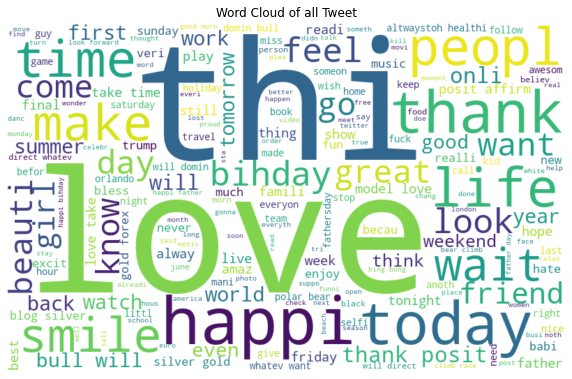

In [25]:
plt.figure(figsize=(10,10))
plt.imshow(wordcloud,interpolation="bilinear")
plt.axis("off")
plt.title("Word Cloud of all Tweet")
plt.show()

#### Hate Tweets

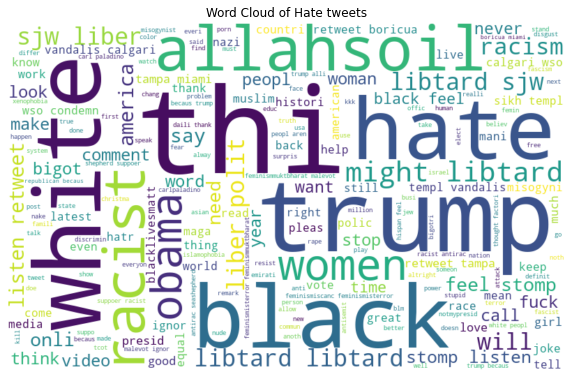

In [26]:
hate_words=' '.join([tweet for tweet in combined["tidy_tweet"][combined["label"]==1]  ])
wordcloud = WordCloud( width =800 ,height =500 ,random_state=10,background_color="white").generate(hate_words)
plt.figure(figsize=(10,10))
plt.imshow(wordcloud,interpolation="bilinear")
plt.axis("off")
plt.title("Word Cloud of Hate tweets")
plt.show()

#### Non Hate Tweets

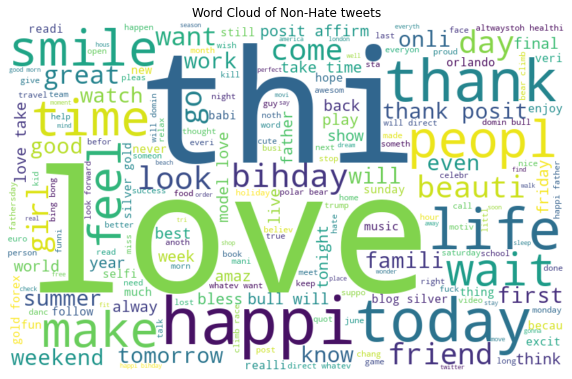

In [27]:
nonhate_words=' '.join([tweet for tweet in combined["tidy_tweet"][combined["label"]==0]  ])
wordcloud = WordCloud( width =800 ,height =500 ,random_state=10,background_color="white").generate(nonhate_words)
plt.figure(figsize=(10,10))
plt.imshow(wordcloud,interpolation="bilinear")
plt.axis("off")
plt.title("Word Cloud of Non-Hate tweets")
plt.show()

### Vizualizing Hash tags

In [28]:
def hashtag_extraction(x):
    hashtag=[]
    for i in x:
        ht = re.findall(r"#(\w+)",i)
        hashtag.append(ht)
    return hashtag

In [29]:
non_hate_ht=hashtag_extraction(combined[combined["label"]==0]["tidy_tweet"])
hate_ht=hashtag_extraction(combined[combined["label"]==1]["tidy_tweet"])

In [30]:
non_hate_ht=sum(non_hate_ht,[]) #Unnesting list
hate_ht=sum(hate_ht,[]) #Unnesting list

In [31]:
nonhateht=nltk.FreqDist(non_hate_ht)

In [32]:
nonhateht=pd.DataFrame({"Hashtag":list(nonhateht.keys()), "Count":list(nonhateht.values())}).nlargest(columns="Count",n=10)

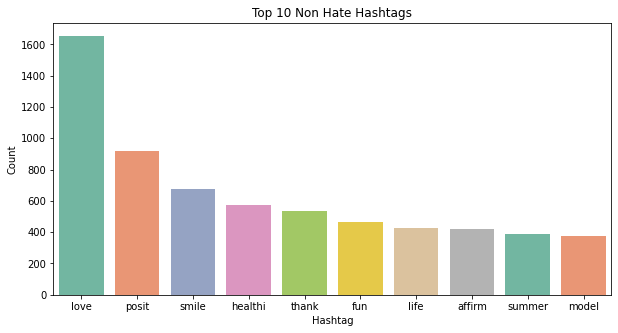

In [33]:
plt.figure(figsize=(10,5))
sns.barplot(x="Hashtag",y="Count",data=nonhateht,palette="Set2")
plt.title("Top 10 Non Hate Hashtags")
plt.show()

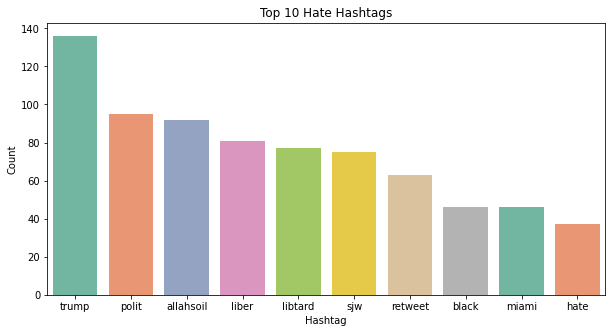

In [34]:
hateht=nltk.FreqDist(hate_ht)
hateht=pd.DataFrame({"Hashtag":list(hateht.keys()), "Count":list(hateht.values())}).nlargest(columns="Count",n=10)
plt.figure(figsize=(10,5))
sns.barplot(x="Hashtag",y="Count",data=hateht,palette="Set2")
plt.title("Top 10 Hate Hashtags")
plt.show()

### Bag of Words

In [35]:
bow_vectorizer =CountVectorizer(max_df=0.90, min_df=2,max_features=1000,stop_words="english" )
bow =bow_vectorizer.fit_transform(combined.tidy_tweet)

In [36]:
bow.shape

(49159, 1000)

### TF-IDF 

In [37]:
tfidf_vectorizer =TfidfVectorizer( max_df= .90,min_df=2,max_features=1000,stop_words="english")
tfidf= tfidf_vectorizer.fit_transform(combined.tidy_tweet)
tfidf.shape

(49159, 1000)

### Data Modelling with Bag of words features

##### Logistic Regression

In [38]:
train_bow,test_bow = bow[:31962,:] , bow[31962:,:]

In [39]:
X_train_bow,X_test_bow,y_train_bow,y_test_bow=train_test_split(train_bow,train["label"],test_size=.3,random_state=42)

In [40]:
Lg=LogisticRegression()
Lg.fit(X_train_bow,y_train_bow)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [41]:
f1_score(y_test_bow,Lg.predict(X_test_bow))

0.48262164846077454

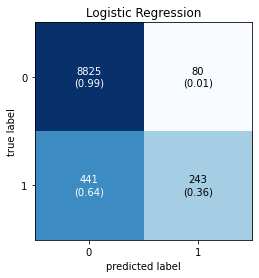

In [42]:
plot_confusion_matrix(conf_mat=confusion_matrix(y_test_bow,Lg.predict(X_test_bow)),show_normed=True)
plt.title("Logistic Regression")
plt.show()

##### Random Forest

In [43]:
rf=RandomForestClassifier(n_estimators=400,random_state=11)
rf.fit(X_train_bow,y_train_bow)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=400,
                       n_jobs=None, oob_score=False, random_state=11, verbose=0,
                       warm_start=False)

In [44]:
f1_score(y_test_bow,rf.predict(X_test_bow))

0.5529225908372828

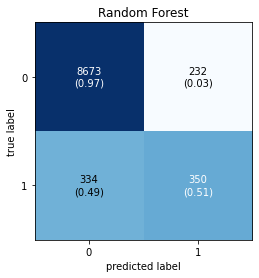

In [45]:
plot_confusion_matrix(conf_mat=confusion_matrix(y_test_bow,rf.predict(X_test_bow)),show_normed=True)
plt.title("Random Forest")
plt.show()

##### XGB Classifier

In [46]:
xgb=XGBClassifier(max_depth=6 ,n_estimators=1000)
xgb.fit(X_train_bow,y_train_bow)

XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=1000, n_jobs=0, num_parallel_tree=1,
              objective='binary:logistic', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method=None,
              validate_parameters=False, verbosity=None)

In [47]:
f1_score(y_test_bow,xgb.predict(X_test_bow))

0.5247706422018349

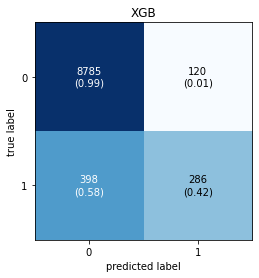

In [48]:
plot_confusion_matrix(conf_mat=confusion_matrix(y_test_bow,xgb.predict(X_test_bow)),show_normed=True)
plt.title("XGB")
plt.show()

### Data Modelling with TFIDF features

##### Logistic Regression

In [49]:
train_tfidf,test_tfidf = tfidf[:31962,:] , tfidf[31962:,:]

In [50]:
X_train_tfidf,X_test_tfidf,y_train_tfidf,y_test_tfidf=train_test_split(train_tfidf,train["label"],test_size=.3,random_state=42)

In [51]:
Lg=LogisticRegression()
Lg.fit(X_train_tfidf,y_train_tfidf)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [52]:
f1_score(y_test_tfidf,Lg.predict(X_test_tfidf))

0.45877378435517974

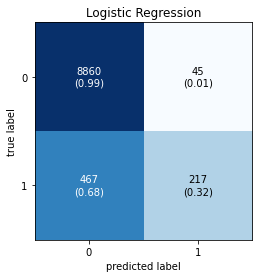

In [53]:
plot_confusion_matrix(conf_mat=confusion_matrix(y_test_tfidf,Lg.predict(X_test_tfidf)),show_normed=True)
plt.title("Logistic Regression")
plt.show()

##### Random Forest

In [54]:
rf=RandomForestClassifier(n_estimators=400,random_state=11)
rf.fit(X_train_tfidf,y_train_tfidf)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=400,
                       n_jobs=None, oob_score=False, random_state=11, verbose=0,
                       warm_start=False)

In [55]:
f1_score(y_test_tfidf,rf.predict(X_test_tfidf))

0.562152133580705

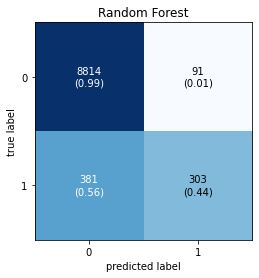

In [56]:
plot_confusion_matrix(conf_mat=confusion_matrix(y_test_tfidf,rf.predict(X_test_tfidf)),show_normed=True)
plt.title("Random Forest")
plt.show()

##### XGB Classifier

In [57]:
xgb=XGBClassifier(max_depth=6 ,n_estimators=1000)
xgb.fit(X_train_tfidf,y_train_tfidf)

XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=1000, n_jobs=0, num_parallel_tree=1,
              objective='binary:logistic', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method=None,
              validate_parameters=False, verbosity=None)

In [58]:
f1_score(y_test_tfidf,xgb.predict(X_test_tfidf))

0.5394265232974911

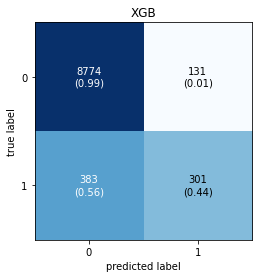

In [59]:
plot_confusion_matrix(conf_mat=confusion_matrix(y_test_tfidf,xgb.predict(X_test_tfidf)),show_normed=True)
plt.title("XGB")
plt.show()